In [20]:
# attention head increase had no effect in 1 epoch
# increase in batch size had very small effect in 1 epoch 






# Loop

In [21]:
import torch 
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# building a training set using torchvision's MNIST dataset
class KernelDataset(Dataset):
    def __init__(self,kernel,noise_std= 0.0, train = True):
        self.ds = datasets.MNIST(
            root = '.',
            train = train,
            download = True,
            transform = transforms.ToTensor()
        )

    # we make a copy of our kernel just in case
        self.kernel = kernel.clone().float()
        self.padding = kernel.size(-1) // 2
        self.noise_std = noise_std
    # define getitem and len 
    # 1) grab image at index idx,
    # 2) apply 2D convolution to x
    # 3) pytorch expects batches so we unsqueeze input and squeeze output ( to set batch size as 1)
    
    def __getitem__(self,idx):
        x, _  = self.ds[idx]
        x = x.float().unsqueeze(0)
        if self.noise_std > 0:
            x = x + torch.randn_like(x) * self.noise_std        
        y = F.conv2d(x, self.kernel, padding=self.padding).squeeze(0)
            
        return x.squeeze(0), y

    def __len__(self):
        return len(self.ds)
# Define test architectures

# single convolution layer neuron: input > convolution > output
class CNN(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        padding = kernel_size//2
        #self.conv = nn.Conv2d(1,1,3,padding = 1, bias = False)
        self.conv = nn.Conv2d(1,1,kernel_size,padding = padding, bias = False)

    def forward(self,x):
        return self.conv(x)

#  1-layer linear neuron (not techincally MLP) has no activation function
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,784), #1*28*28
            nn.Unflatten(1,(1,28,28))
        )
    def forward(self,x):
        return self.net(x)


        
## transformers ingest vectors (tokens), not images, so must convert input 
# we make sequences of patches (cut-outs) of each image using a 1x1 convolution and convert to a sequence of tokens

class Transformer(nn.Module):
    def __init__(self,dim = 32):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels = 1, out_channels = dim, kernel_size = 1)
        self.encoder = nn.TransformerEncoderLayer(
            d_model = dim,
            nhead = 4, 
            batch_first = True
        )
        self.unpatch = nn.Conv2d(in_channels = dim, out_channels = 1, kernel_size = 1)
        
    def forward(self,x):
        B,C,H,W = x.shape
        # Patch and reshape into sequence of tokens
        x= self.patch_embed(x) 
        x = x.flatten(2) 
        x = x.transpose(1,2) 

        # Pass through transformer
        x = self.encoder(x)
        
        # Reshape and project back to 1 channel image
        x = x.transpose(1,2)
        if x.size(2) != H * W:
          raise ValueError(f"Shape mismatch: expected {H * W} elements, got {x.size(2)}")
            
        x = x.view(B,-1,H,W)
        out = self.unpatch(x)

        return out

def train(model, train_loader, val_loader, epochs = 5, lr = 1e-3,mse_cutoff=1e-6):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    # and we'll use mean squared error to calculate loss
    loss_fun = nn.MSELoss()

    # training step: forward > calculate loss > optimize via gradient des > update > print loss
    for ep in range(epochs):
        model.train()
        total = 0

        # for each pair of (image, label) compute on GPU, use loss function to 
     
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            # calculate gradients 
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fun(pred, y)
            loss.backward()
            # and update weights 
            optimizer.step()

            # we keep track of total loss
            total+= loss.item()
            
        print(f"Epoch {ep+1}: train loss = {total/len(train_loader):.6f}")

        # validation step: forward > loss > print loss
        modelInstance.eval()
        with torch.no_grad():
            model.eval()
            val_total = 0
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)

                pred = model(x)
                val_loss = loss_fun(pred,y)
                val_total += val_loss.item()
            print(f" val loss = {val_total/len(val_loader):.6f}")
            if val_loss <= mse_cutoff:
                print(f"Stopping early: validation MSE reached {val_loss:.3e} ≤ {mse_cutoff}")
                break
            


Applying a noise of bell curve size 0.0

=== Sobel 3×3 ===
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])
Training CNN
Epoch 1: train loss = 0.036364
 val loss = 0.002698
Epoch 2: train loss = 0.001459
 val loss = 0.000665
Epoch 3: train loss = 0.000340
 val loss = 0.000127
Epoch 4: train loss = 0.000061
 val loss = 0.000023
Epoch 5: train loss = 0.000011
 val loss = 0.000004
CNN vs Sobel 3x3 MSE error is: 3.3579428873053985e-06


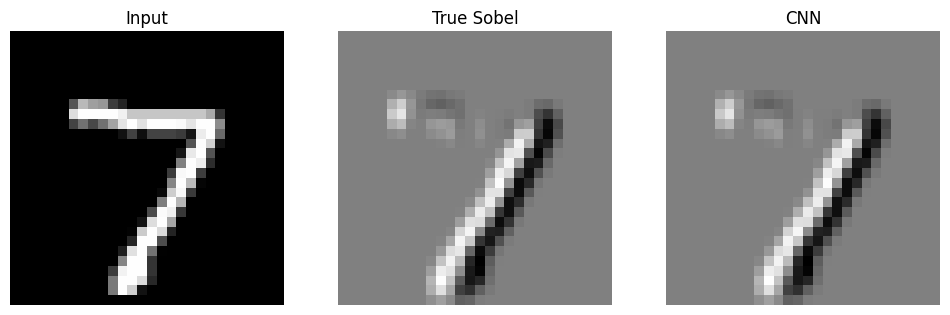

Training MLP
Epoch 1: train loss = 0.011615
 val loss = 0.001701
Epoch 2: train loss = 0.000760
 val loss = 0.000274
Epoch 3: train loss = 0.000129
 val loss = 0.000057
Epoch 4: train loss = 0.000035
 val loss = 0.000019
Epoch 5: train loss = 0.000023
 val loss = 0.000018
MLP vs Sobel 3x3 MSE error is: 1.5024697859189473e-05


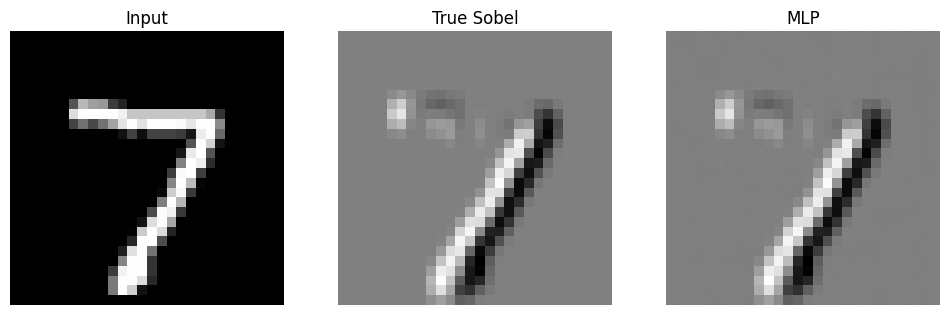


=== Sobel 5×5 ===
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])
Training CNN
Epoch 1: train loss = 0.023237
 val loss = 0.001101
Epoch 2: train loss = 0.000424
 val loss = 0.000161
Epoch 3: train loss = 0.000090
 val loss = 0.000041
Epoch 4: train loss = 0.000020
 val loss = 0.000007
Epoch 5: train loss = 0.000003
 val loss = 0.000000
Stopping early: validation MSE reached 5.249e-07 ≤ 1e-06
CNN vs Sobel 5x5 MSE error is: 4.343484647506557e-07


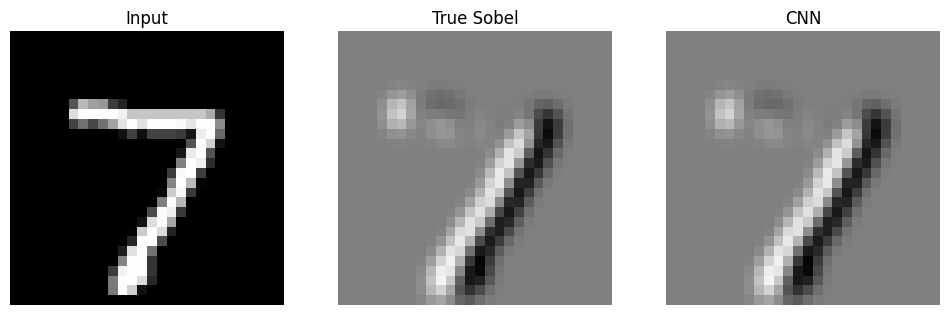

Training MLP
Epoch 1: train loss = 0.020507
 val loss = 0.001287
Epoch 2: train loss = 0.000496
 val loss = 0.000147
Epoch 3: train loss = 0.000071
 val loss = 0.000039
Epoch 4: train loss = 0.000022
 val loss = 0.000014
Epoch 5: train loss = 0.000020
 val loss = 0.000039
MLP vs Sobel 5x5 MSE error is: 3.047103928111028e-05


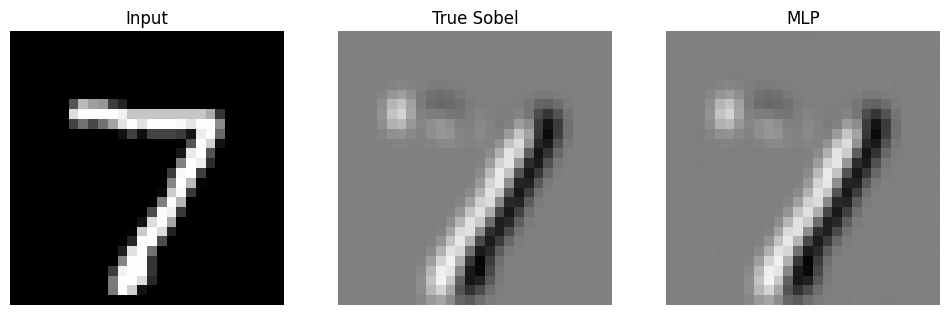


=== Sobel 7×7 ===
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])
Training CNN
Epoch 1: train loss = 0.021889
 val loss = 0.000681
Epoch 2: train loss = 0.000296
 val loss = 0.000111
Epoch 3: train loss = 0.000056
 val loss = 0.000023
Epoch 4: train loss = 0.000010
 val loss = 0.000003
Epoch 5: train loss = 0.000001
 val loss = 0.000000
Stopping early: validation MSE reached 2.015e-07 ≤ 1e-06
CNN vs Sobel 7x7 MSE error is: 1.73629075561621e-07


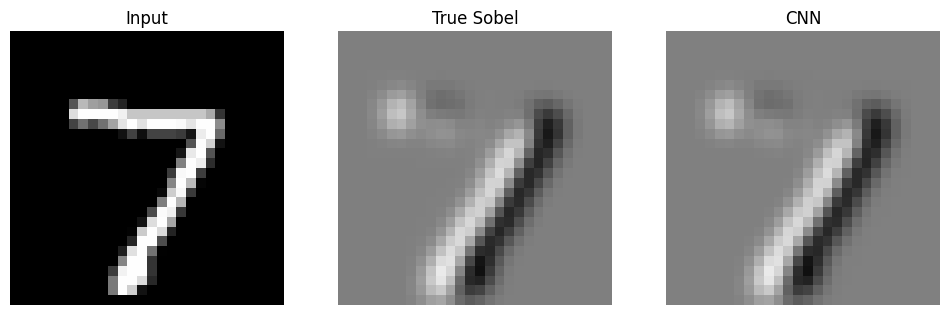

Training MLP
Epoch 1: train loss = 0.026927
 val loss = 0.000936
Epoch 2: train loss = 0.000361
 val loss = 0.000114
Epoch 3: train loss = 0.000057
 val loss = 0.000027
Epoch 4: train loss = 0.000021
 val loss = 0.000037
Epoch 5: train loss = 0.000019
 val loss = 0.000039
MLP vs Sobel 7x7 MSE error is: 2.971547655761242e-05


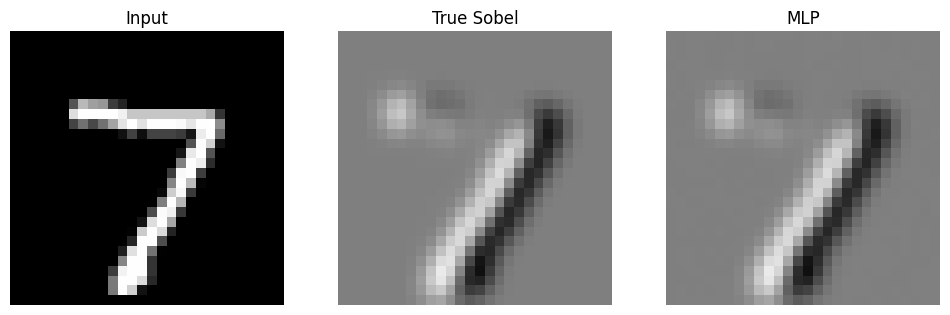


=== Sobel 9×9 ===
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])
Training CNN
Epoch 1: train loss = 0.065662
 val loss = 0.001847
Epoch 2: train 

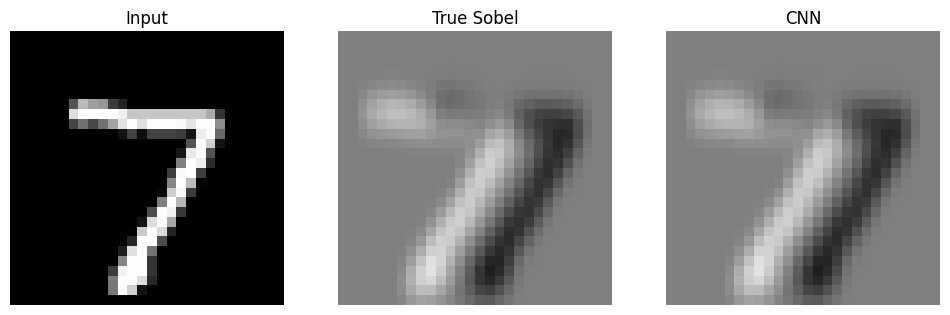

Training MLP
Epoch 1: train loss = 0.034190
 val loss = 0.001265
Epoch 2: train loss = 0.000548
 val loss = 0.000206
Epoch 3: train loss = 0.000104
 val loss = 0.000049
Epoch 4: train loss = 0.000027
 val loss = 0.000013
Epoch 5: train loss = 0.000018
 val loss = 0.000015
MLP vs Sobel 9x9 MSE error is: 1.2345663890300784e-05


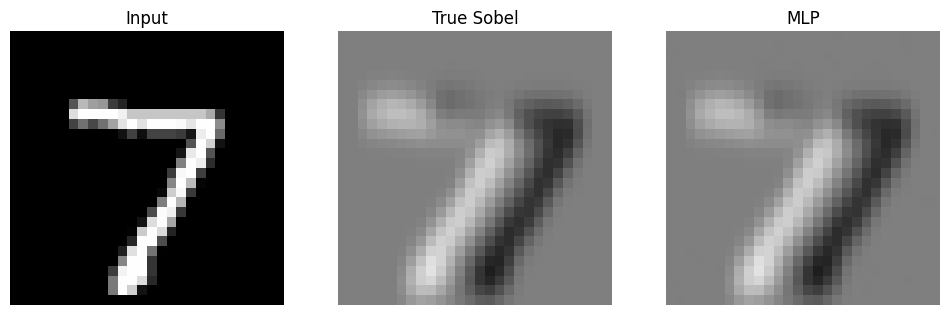

Applying a noise of bell curve size 0.05

=== Sobel 3×3 ===
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])
Training CNN
Epoch 1: train loss = 0.012448
 val loss = 0.002147
Epoch 2: train loss = 0.001452
 val loss = 0.000379
Epoch 3: train loss = 0.000238
 val loss = 0.000036
Epoch 4: train loss = 0.000017
 val loss = 0.000001
Stopping early: validation MSE reached 9.154e-07 ≤ 1e-06
CNN vs Sobel 3x3 MSE error is: 7.921750579953368e-07


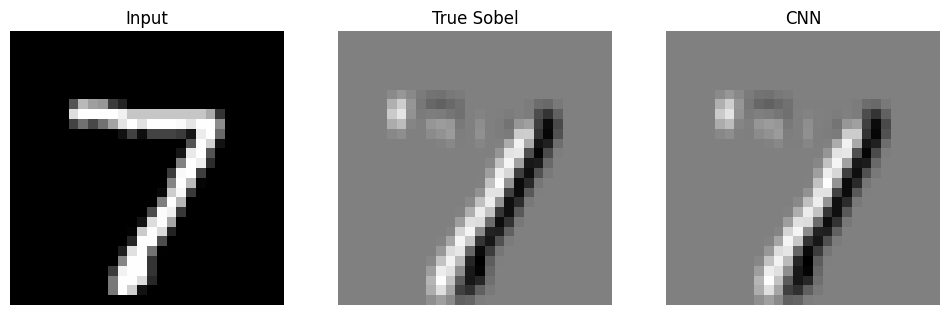

Training MLP
Epoch 1: train loss = 0.012709
 val loss = 0.001419
Epoch 2: train loss = 0.000699
 val loss = 0.000145
Epoch 3: train loss = 0.000073
 val loss = 0.000021
Epoch 4: train loss = 0.000021
 val loss = 0.000015
Epoch 5: train loss = 0.000026
 val loss = 0.000015
MLP vs Sobel 3x3 MSE error is: 1.3293845768203028e-05


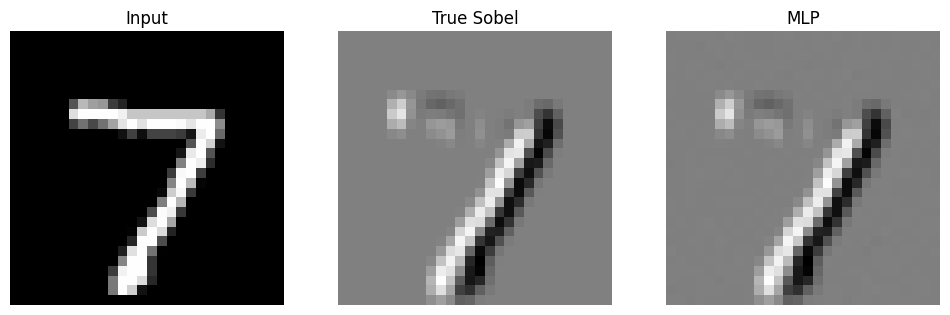


=== Sobel 5×5 ===
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])
Training CNN
Epoch 1: train loss = 0.031239
 val loss = 0.000974
Epoch 2: train loss = 0.000628
 val loss = 0.000163
Epoch 3: train loss = 0.000128
 val loss = 0.000025
Epoch 4: train loss = 0.000018
 val loss = 0.000002
Epoch 5: train loss = 0.000001
 val loss = 0.000000
Stopping early: validation MSE reached 8.605e-08 ≤ 1e-06
CNN vs Sobel 5x5 MSE error is: 6.9585126993843e-08


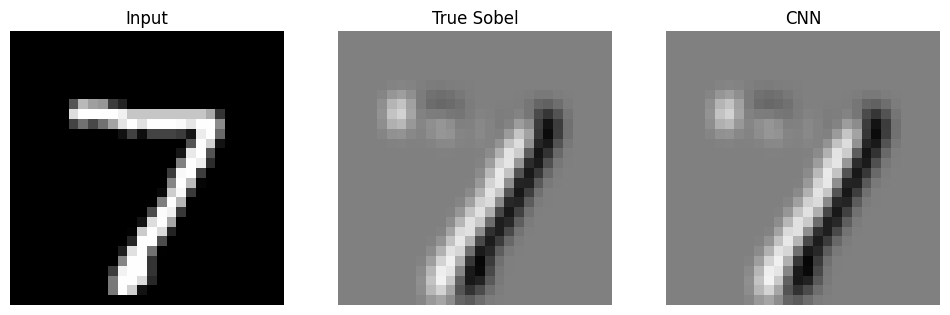

Training MLP
Epoch 1: train loss = 0.021337
 val loss = 0.001059
Epoch 2: train loss = 0.000442
 val loss = 0.000080
Epoch 3: train loss = 0.000040
 val loss = 0.000022
Epoch 4: train loss = 0.000016
 val loss = 0.000017
Epoch 5: train loss = 0.000023
 val loss = 0.000020
MLP vs Sobel 5x5 MSE error is: 1.6802056052256376e-05


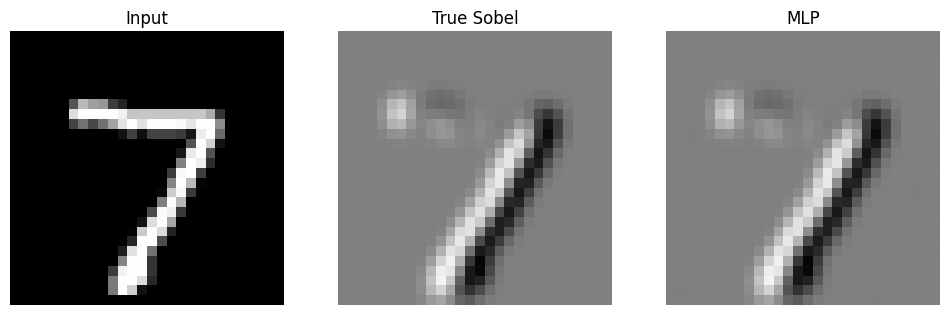


=== Sobel 7×7 ===
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])
Training CNN
Epoch 1: train loss = 0.029607
 val loss = 0.000759
Epoch 2: train loss = 0.000406
 val loss = 0.000094
Epoch 3: train loss = 0.000069
 val loss = 0.000013
Epoch 4: train loss = 0.000009
 val loss = 0.000001
Epoch 5: train loss = 0.000001
 val loss = 0.000000
Stopping early: validation MSE reached 3.447e-08 ≤ 1e-06
CNN vs Sobel 7x7 MSE error is: 2.8226027737332515e-08


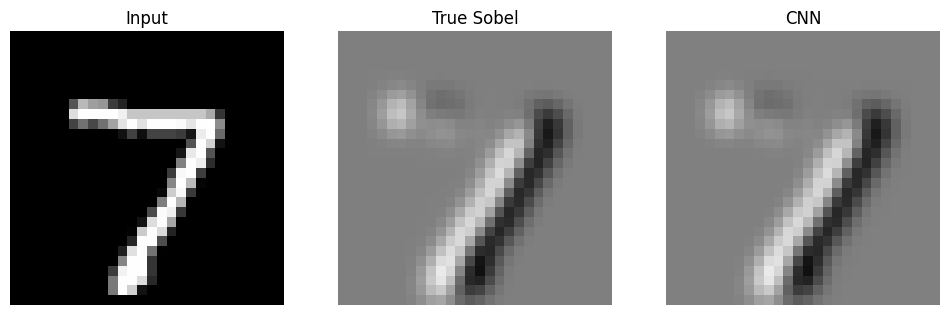

Training MLP
Epoch 1: train loss = 0.027541
 val loss = 0.000765
Epoch 2: train loss = 0.000320
 val loss = 0.000060
Epoch 3: train loss = 0.000033
 val loss = 0.000012
Epoch 4: train loss = 0.000016
 val loss = 0.000011
Epoch 5: train loss = 0.000020
 val loss = 0.000020
MLP vs Sobel 7x7 MSE error is: 1.6980484360828996e-05


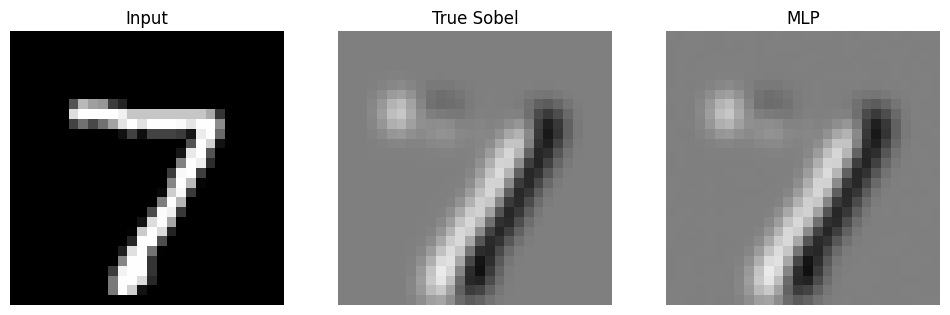


=== Sobel 9×9 ===
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])
Training CNN
Epoch 1: train loss = 0.037856
 val loss = 0.000630
Epoch 2: train 

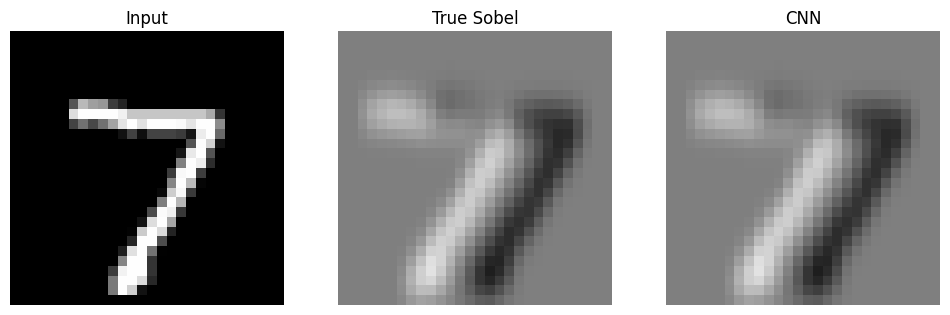

Training MLP
Epoch 1: train loss = 0.035099
 val loss = 0.001096
Epoch 2: train loss = 0.000533
 val loss = 0.000135
Epoch 3: train loss = 0.000077
 val loss = 0.000023
Epoch 4: train loss = 0.000017
 val loss = 0.000016
Epoch 5: train loss = 0.000018
 val loss = 0.000011
MLP vs Sobel 9x9 MSE error is: 9.769919415703043e-06


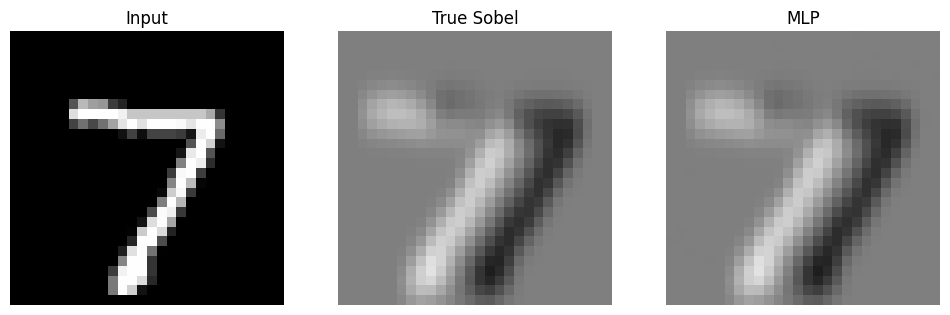

Applying a noise of bell curve size 0.1

=== Sobel 3×3 ===
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])
Training CNN
Epoch 1: train loss = 0.018632
 val loss = 0.001603
Epoch 2: train loss = 0.001463
 val loss = 0.000097
Epoch 3: train loss = 0.000060
 val loss = 0.000001
Epoch 4: train loss = 0.000000
 val loss = 0.000000
Stopping early: validation MSE reached 5.658e-10 ≤ 1e-06
CNN vs Sobel 3x3 MSE error is: 5.171134076498163e-10


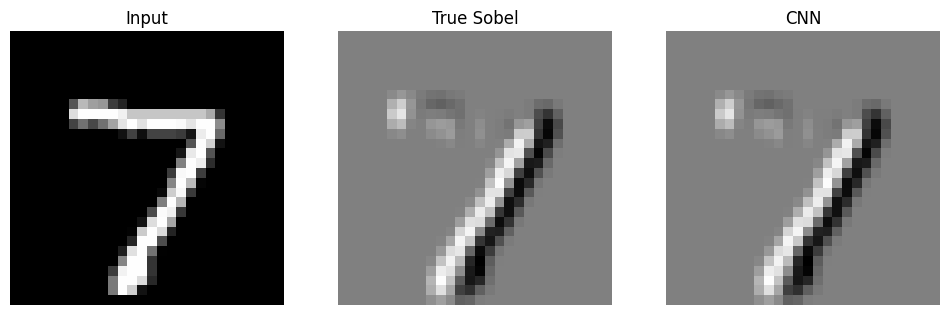

Training MLP
Epoch 1: train loss = 0.015031
 val loss = 0.000997
Epoch 2: train loss = 0.000569
 val loss = 0.000051
Epoch 3: train loss = 0.000029
 val loss = 0.000002
Epoch 4: train loss = 0.000011
 val loss = 0.000017
Epoch 5: train loss = 0.000032
 val loss = 0.000027
MLP vs Sobel 3x3 MSE error is: 2.412449975963682e-05


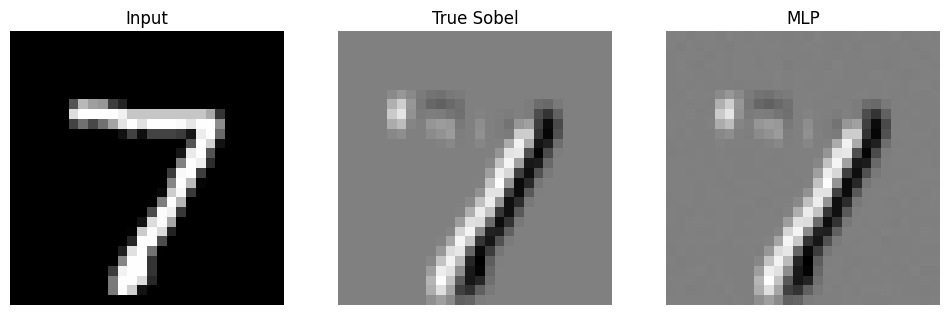


=== Sobel 5×5 ===
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])
Training CNN
Epoch 1: train loss = 0.021329
 val loss = 0.000528
Epoch 2: train loss = 0.000401
 val loss = 0.000035
Epoch 3: train loss = 0.000025
 val loss = 0.000001
Stopping early: validation MSE reached 9.704e-07 ≤ 1e-06
CNN vs Sobel 5x5 MSE error is: 8.536661084690422e-07


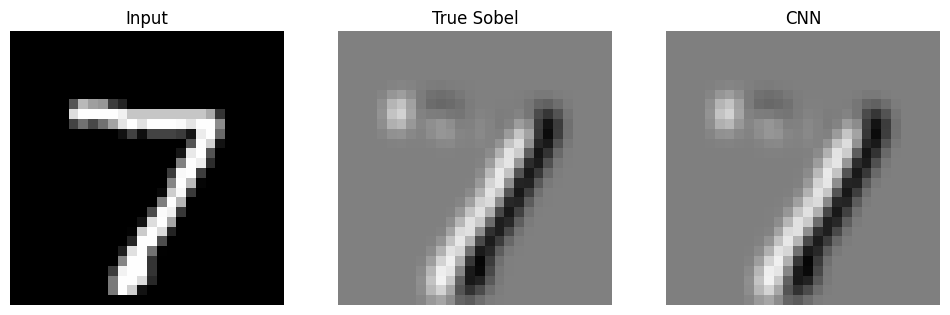

Training MLP
Epoch 1: train loss = 0.023228
 val loss = 0.000766
Epoch 2: train loss = 0.000357
 val loss = 0.000032
Epoch 3: train loss = 0.000018
 val loss = 0.000001
Epoch 4: train loss = 0.000017
 val loss = 0.000014
Epoch 5: train loss = 0.000026
 val loss = 0.000028
MLP vs Sobel 5x5 MSE error is: 2.2877235096530057e-05


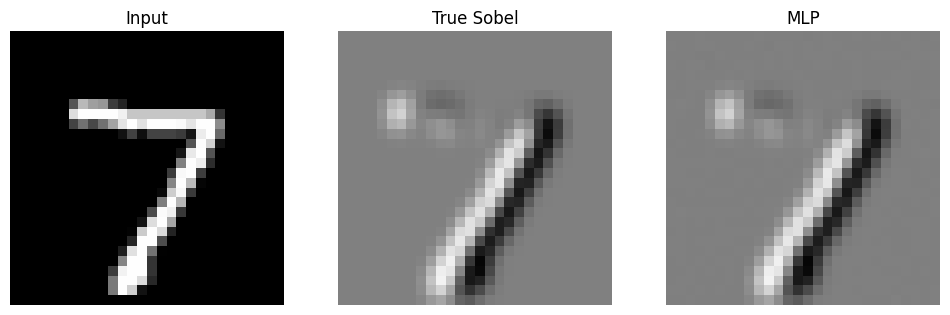


=== Sobel 7×7 ===
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])
Training CNN
Epoch 1: train loss = 0.030634
 val loss = 0.000547
Epoch 2: train loss = 0.000505
 val loss = 0.000037
Epoch 3: train loss = 0.000048
 val loss = 0.000002
Epoch 4: train loss = 0.000002
 val loss = 0.000000
Stopping early: validation MSE reached 3.526e-08 ≤ 1e-06
CNN vs Sobel 7x7 MSE error is: 2.894917372486816e-08


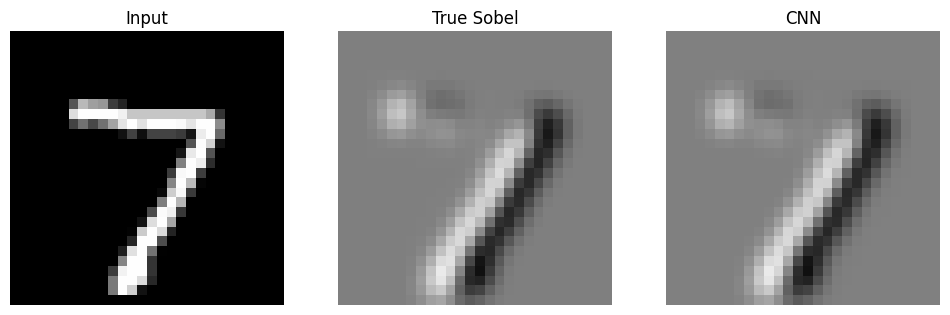

Training MLP
Epoch 1: train loss = 0.029527
 val loss = 0.000559
Epoch 2: train loss = 0.000259
 val loss = 0.000023
Epoch 3: train loss = 0.000014
 val loss = 0.000002
Epoch 4: train loss = 0.000017
 val loss = 0.000014
Epoch 5: train loss = 0.000024
 val loss = 0.000029
MLP vs Sobel 7x7 MSE error is: 2.4807570298435166e-05


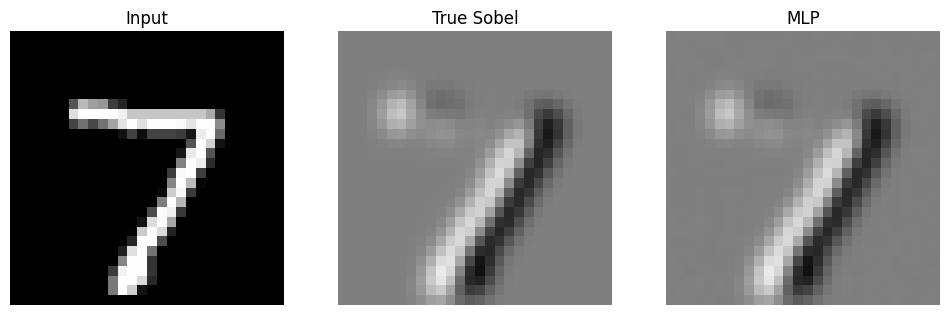


=== Sobel 9×9 ===
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])
Training CNN
Epoch 1: train loss = 0.046813
 val loss = 0.000371
Epoch 2: train 

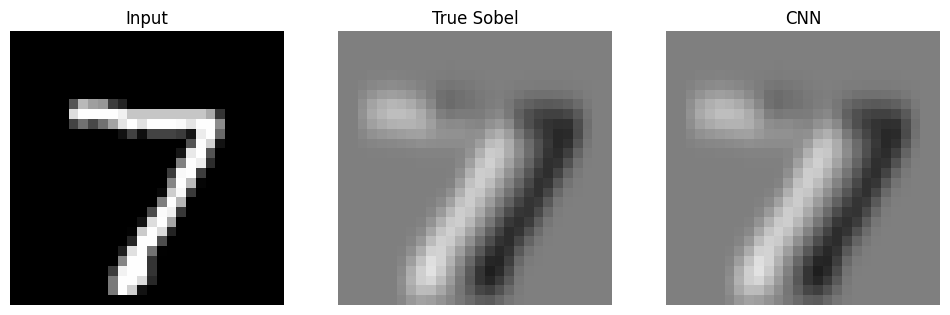

Training MLP
Epoch 1: train loss = 0.037061
 val loss = 0.000817
Epoch 2: train loss = 0.000447
 val loss = 0.000059
Epoch 3: train loss = 0.000038
 val loss = 0.000011
Epoch 4: train loss = 0.000014
 val loss = 0.000018
Epoch 5: train loss = 0.000022
 val loss = 0.000032
MLP vs Sobel 9x9 MSE error is: 2.728724393818993e-05


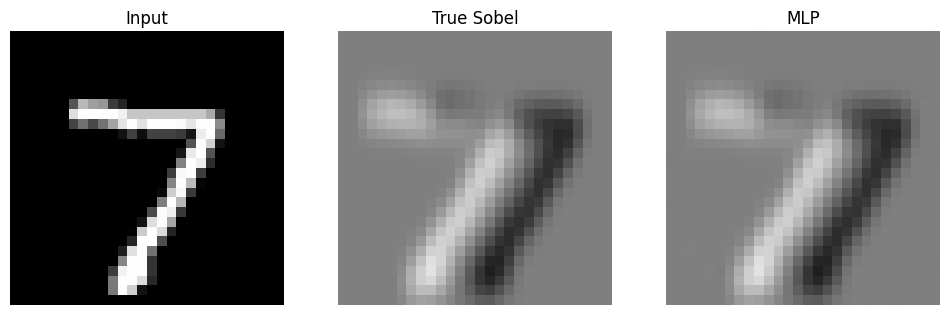

Applying a noise of bell curve size 0.2

=== Sobel 3×3 ===
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])
Training CNN
Epoch 1: train loss = 0.055907
 val loss = 0.001374
Epoch 2: train loss = 0.001133
 val loss = 0.000023
Epoch 3: train loss = 0.000031
 val loss = 0.000000
Stopping early: validation MSE reached 1.813e-07 ≤ 1e-06
CNN vs Sobel 3x3 MSE error is: 1.7152326847735822e-07


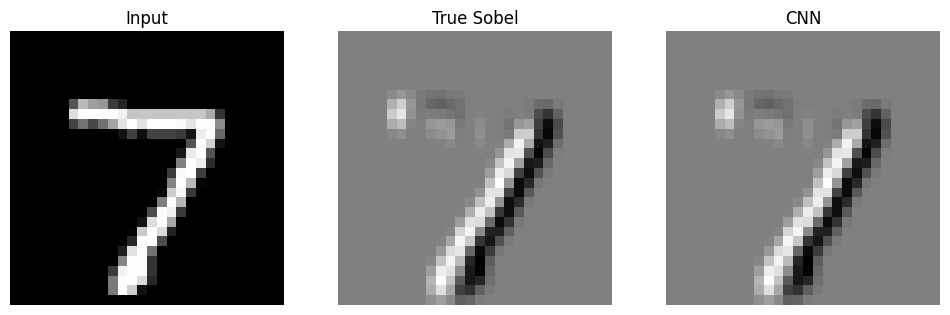

Training MLP
Epoch 1: train loss = 0.023524
 val loss = 0.000480
Epoch 2: train loss = 0.000354
 val loss = 0.000005
Epoch 3: train loss = 0.000003
 val loss = 0.000000
Stopping early: validation MSE reached 1.439e-08 ≤ 1e-06
MLP vs Sobel 3x3 MSE error is: 9.602626249716195e-09


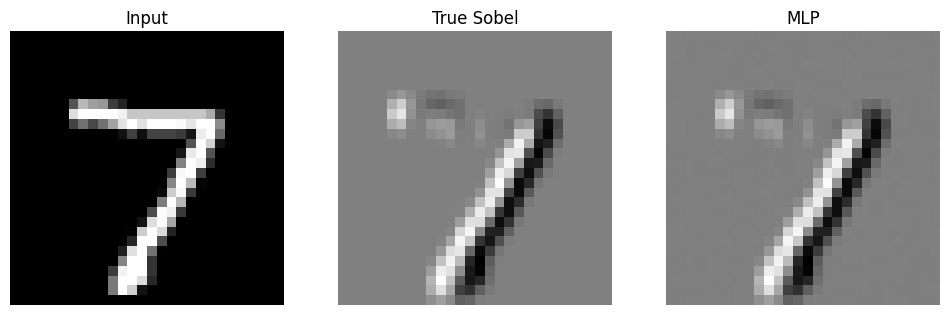


=== Sobel 5×5 ===
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])
Training CNN
Epoch 1: train loss = 0.056056
 val loss = 0.000641
Epoch 2: train loss = 0.000581
 val loss = 0.000004
Epoch 3: train loss = 0.000004
 val loss = 0.000000
Stopping early: validation MSE reached 3.580e-09 ≤ 1e-06
CNN vs Sobel 5x5 MSE error is: 3.3939850929698423e-09


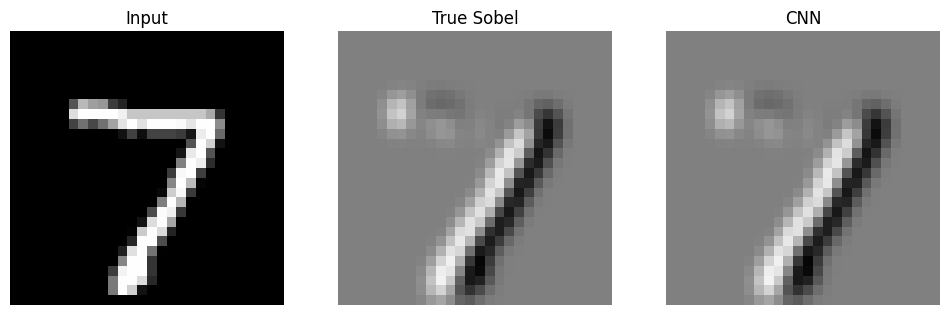

Training MLP
Epoch 1: train loss = 0.029685
 val loss = 0.000353
Epoch 2: train loss = 0.000199
 val loss = 0.000004
Epoch 3: train loss = 0.000002
 val loss = 0.000000
Stopping early: validation MSE reached 2.019e-08 ≤ 1e-06
MLP vs Sobel 5x5 MSE error is: 1.6012823067512727e-08


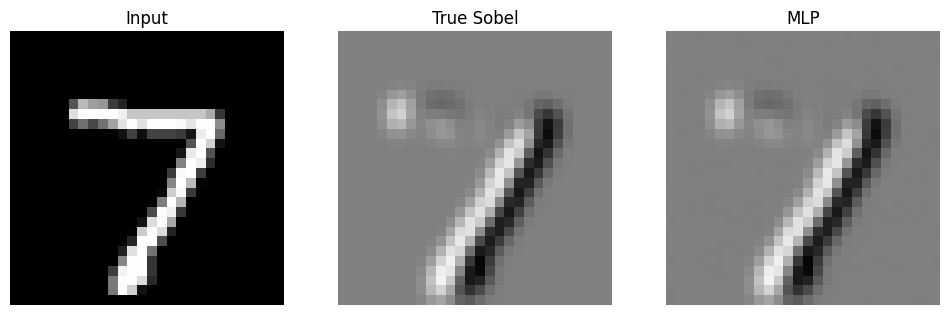


=== Sobel 7×7 ===
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])
Training CNN
Epoch 1: train loss = 0.044999
 val loss = 0.000123
Epoch 2: train loss = 0.000174
 val loss = 0.000001
Stopping early: validation MSE reached 9.815e-07 ≤ 1e-06
CNN vs Sobel 7x7 MSE error is: 8.755152407502464e-07


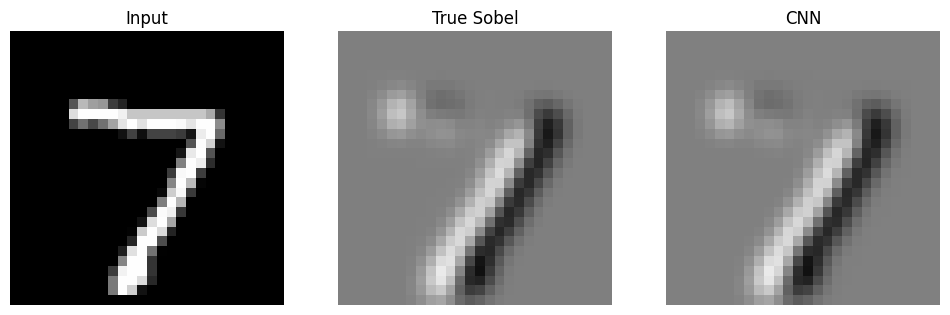

Training MLP
Epoch 1: train loss = 0.034860
 val loss = 0.000245
Epoch 2: train loss = 0.000126
 val loss = 0.000002
Epoch 3: train loss = 0.000001
 val loss = 0.000000
Stopping early: validation MSE reached 1.603e-08 ≤ 1e-06
MLP vs Sobel 7x7 MSE error is: 1.2402648685849726e-08


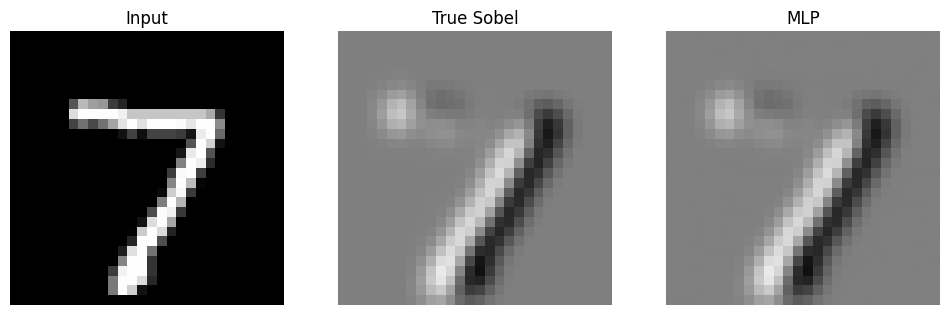


=== Sobel 9×9 ===
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])
Training CNN
Epoch 1: train loss = 0.045371
 val loss = 0.000112
Epoch 2: train 

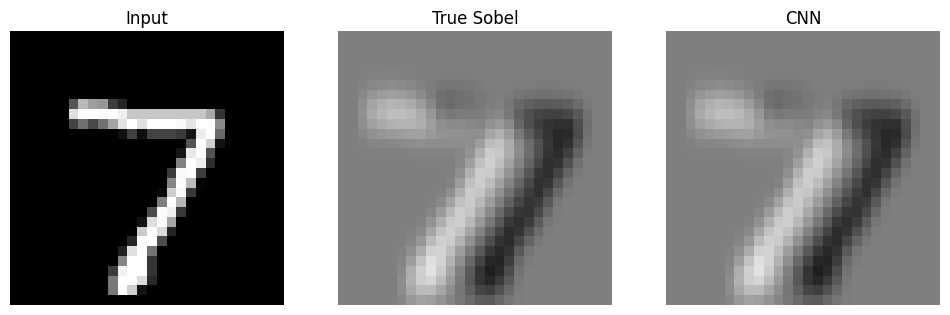

Training MLP
Epoch 1: train loss = 0.042556
 val loss = 0.000363
Epoch 2: train loss = 0.000239
 val loss = 0.000007
Epoch 3: train loss = 0.000005
 val loss = 0.000000
Stopping early: validation MSE reached 8.675e-08 ≤ 1e-06
MLP vs Sobel 9x9 MSE error is: 1.0043143561233592e-07


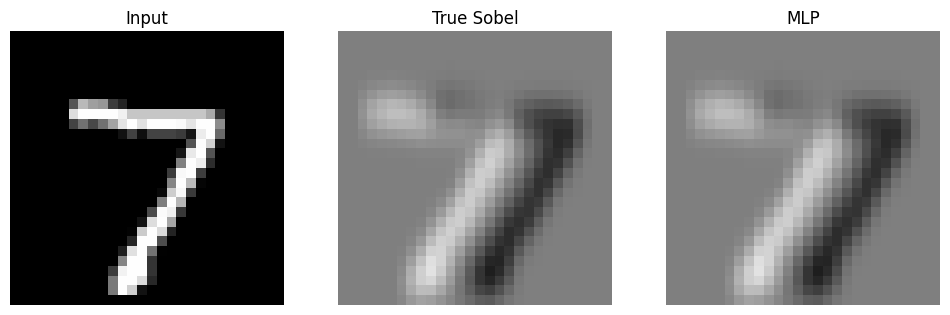

In [22]:
sobel_kernel = torch.tensor([[-1.,0.,1.],
                       [-2.,0.,2.], 
                       [-1.,0.,1.]
                      ])
# need it to be weight of shape (1,1,3,3) 1 for input/output 3x3 for kernel size
sobel_kernel = sobel_kernel.view(1,1,3,3)
sobel_kernel /= torch.norm(sobel_kernel)

sobel_kernel5 = torch.outer( torch.tensor([1,4,6,4,1]), torch.tensor([-1,-2, 0,2,1]) )
sobel_kernel5 = sobel_kernel5.float().view(1,1,5,5)
sobel_kernel5 /= torch.norm(sobel_kernel5)

sobel_kernel7 = torch.outer(torch.tensor([1,6,15,20,15,6,1]),torch.tensor([-1, -2, -3, 0, 3, 2, 1])).float().view(1,1,7,7)
sobel_kernel7 /= torch.norm(sobel_kernel7)

sobel_kernel9 = torch.outer(torch.tensor([1, 8, 28, 56, 70, 56, 28, 8, 1]), torch.tensor([-4, -3, -2, -1, 0, 1, 2, 3, 4])).float().view(1,1,9,9)
sobel_kernel9 /= torch.norm(sobel_kernel9)

noise_levels = [0.0, 0.05, 0.1, 0.2]
kernelSizes = [sobel_kernel, sobel_kernel5, sobel_kernel7,sobel_kernel9]
modelClasses = [CNN, MLP]
phase_data = {model.__name__: {} for model in modelClasses}
image_data = {model.__name__: {} for model in modelClasses}
for noise_std in noise_levels:
    print(f'Applying a noise of bell curve size {noise_std}')
    for architecture in kernelSizes:
        arc_size = architecture.size(-1)
        padding = (arc_size-1)//2
        print(f"\n=== Sobel {arc_size}×{arc_size} ===")
        print(architecture[0,0])
        train_loader = DataLoader(
            KernelDataset(kernel=architecture,noise_std = noise_std, train=True),
            batch_size=64, shuffle=True
        )
        val_loader = DataLoader(
            KernelDataset(kernel=architecture,noise_std = 0.0, train=False),
            batch_size=64
        )
        for modelClass in modelClasses:
            if modelClass is CNN:
                modelInstance = CNN(kernel_size=arc_size)
            else:
                modelInstance = modelClass()
            print(f'Training {modelClass.__name__}')
            train(modelInstance, train_loader, val_loader, epochs = 5)
            x,_ = next(iter(val_loader))
            x = x.to(device)
            
            sobel = architecture.to(device) 
            
            with torch.no_grad():
                true_sobel = F.conv2d(x,sobel, stride = 1, padding = padding)
                pred = modelInstance(x)
                mse = F.mse_loss(pred,true_sobel)
            print("{} vs Sobel {}x{} MSE error is: {}".format(modelClass.__name__,arc_size, arc_size ,mse.item()))
            phase_data[modelClass.__name__][(arc_size, noise_std)] = mse.item()
            image_data[modelClass.__name__][(arc_size, noise_std)] = {"pred": pred[0, 0].detach().cpu(),"true": true_sobel[0, 0].detach().cpu()}
            
            vmin = true_sobel.min().item()
            vmax = true_sobel.max().item()
    
            plt.figure(figsize=(12,4))
    
            plt.subplot(1,3,1)
            plt.title("Input")
            plt.imshow(x[0,0].cpu(), cmap="gray")
            plt.axis("off")
    
            plt.subplot(1,3,2)
            plt.title("True Sobel")
            plt.imshow(true_sobel[0,0].cpu(), cmap="gray", vmin=vmin, vmax=vmax)
            plt.axis("off")
    
            plt.subplot(1,3,3)
            plt.title(modelClass.__name__)
            plt.imshow(pred[0,0].cpu(), cmap="gray", vmin=vmin, vmax=vmax)
            plt.axis("off")
    
            plt.show()

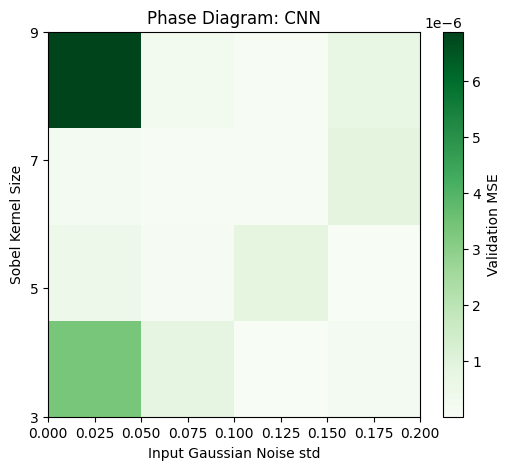

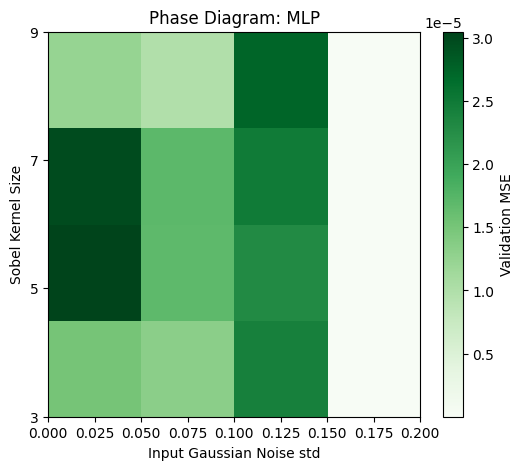

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Make lists for kernel sizes and noise levels
kernel_sizes = [3, 5, 7, 9]
noise_levels = [0.0, 0.05, 0.1, 0.2]

for model_name, data in phase_data.items():
    # MSE matrix w/ entries (kernel size, noise) for entries in lists above
    mse_matrix = np.full((len(kernel_sizes), len(noise_levels)), np.nan)
    for i, k in enumerate(kernel_sizes):
        for j, noise in enumerate(noise_levels):
            mse_matrix[i, j] = data.get((k, noise), np.nan)

    plt.figure(figsize=(6,5))
    plt.imshow(mse_matrix, 
               origin='lower', 
               aspect='auto', 
               cmap='Greens', 
               extent=[min(noise_levels), max(noise_levels), min(kernel_sizes), max(kernel_sizes)])
    plt.colorbar(label='Validation MSE')
    plt.xlabel('Input Gaussian Noise std')
    plt.ylabel('Sobel Kernel Size')
    plt.title(f'Phase Diagram: {model_name}')
    plt.yticks(kernel_sizes)
    plt.show()

    mse_matrix


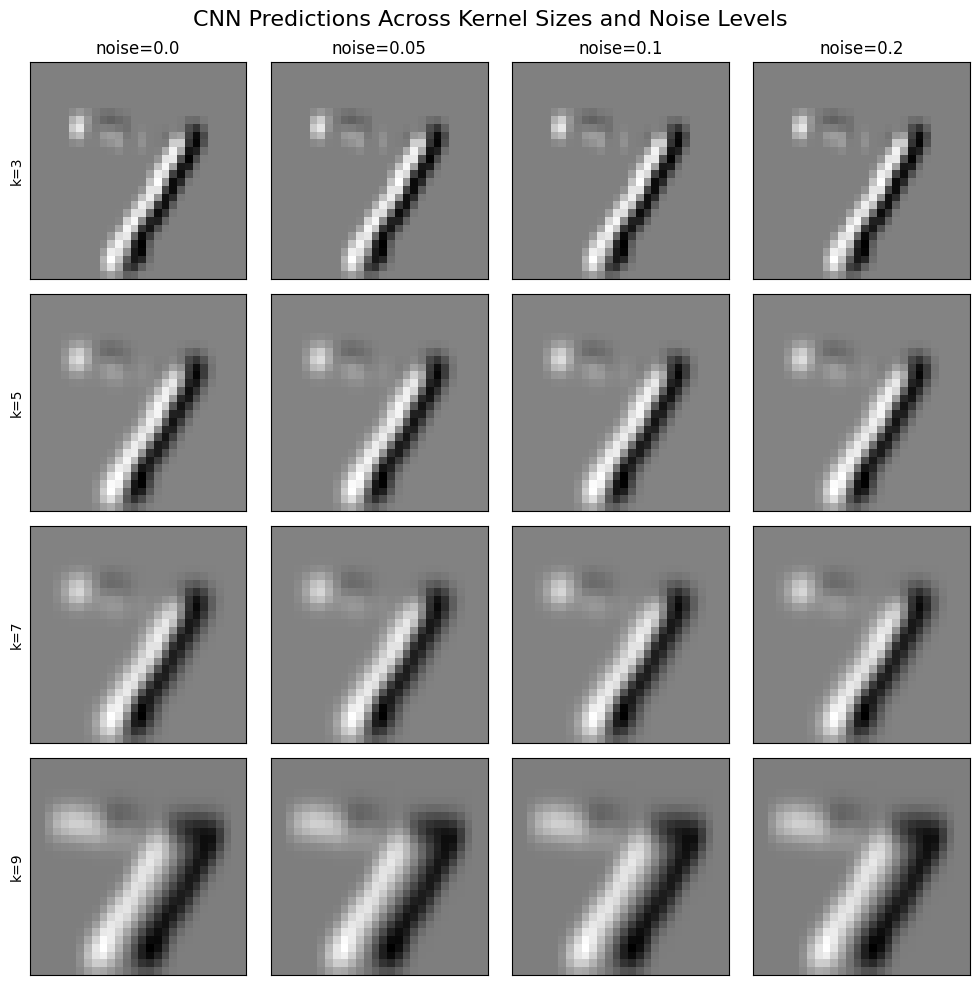

In [30]:
fig, axes = plt.subplots(len(kernel_sizes), len(noise_levels), figsize=(10,10))
fig.suptitle("CNN Predictions Across Kernel Sizes and Noise Levels", fontsize=16)

for i, k in enumerate(kernel_sizes):
    for j, n in enumerate(noise_levels):
        ax = axes[i, j]
        ax.imshow(image_data["CNN"][(k,n)]["pred"], cmap="gray")
        
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f"noise={n}")
        if j == 0:
            ax.set_ylabel(f"k={k}")
plt.tight_layout()
plt.show()


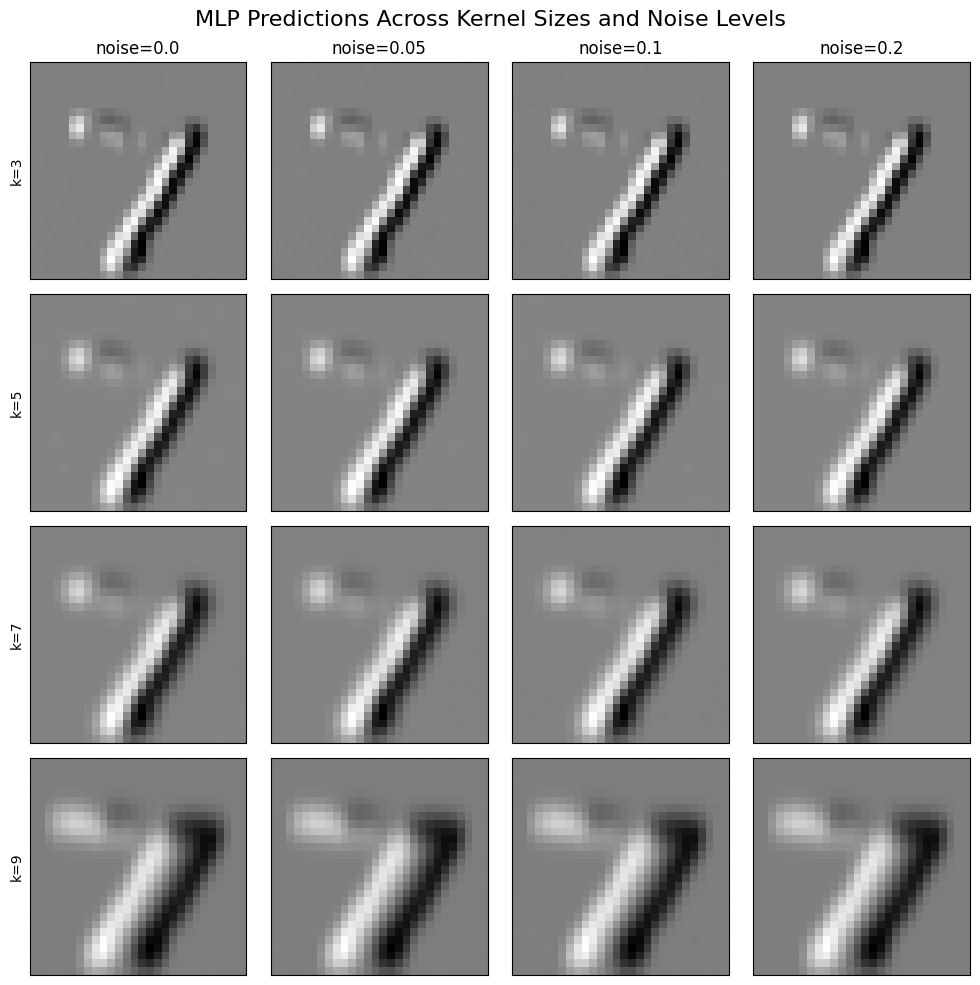

In [31]:
fig, axes = plt.subplots(len(kernel_sizes), len(noise_levels), figsize=(10,10))
fig.suptitle("MLP Predictions Across Kernel Sizes and Noise Levels", fontsize=16)

for i, k in enumerate(kernel_sizes):
    for j, n in enumerate(noise_levels):
        ax = axes[i, j]
        ax.imshow(image_data["MLP"][(k,n)]["pred"], cmap="gray")
        
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f"noise={n}")
        if j == 0:
            ax.set_ylabel(f"k={k}")
plt.tight_layout()
plt.show()
